In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, TransformerMixin, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve




In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

mnist.keys() 

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [6]:
X, y = mnist['data'], mnist['target']
y    = y.astype(int)

X.shape, y.shape

((70000, 784), (70000,))

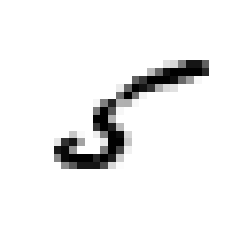

5


In [7]:
%matplotlib inline
index = 11
some_digit = X[index]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()

print(y[index])

In [0]:
# Create a test set and set it aside before further exploration

# X_train, X_test, y_train, y_test = X[:60000],  X[60000:], y[:60000], y[60000:]
# random_index = np.random.permutation(6000)
# Also randomise the train set data for better cross validation

# X_train, y_train = X_train[random_index], y_train[random_index]

# To accomodate data in memory
np.random.seed(42)
train_index = np.random.choice(range(60000),6000, replace=False)
test_index  = np.random.choice(range(60000,70000),1000, replace=False)

X_train, X_test, y_train, y_test = X[train_index],  X[test_index], y[train_index], y[test_index]


In [9]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5  = (y_test== 5)

sgd_clf   = SGDClassifier(random_state=42)

sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])


array([ True])

In [10]:
# Custom made cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

# Clonining should be done inside the loop to have a new classifier each time
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf       = clone(sgd_clf)
    X_train_folds   = X_train[train_index]
    y_train_folds   = y_train_5[train_index]
    X_test_fold     = X_train[test_index]
    y_test_fold     = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred          = clone_clf.predict(X_test_fold)
    n_correct       = sum(y_test_fold == y_pred)
    print(n_correct/len(y_pred))
    
    
    


0.9400299850074962
0.9565
0.9399699849924963


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.94002999, 0.9565    , 0.93996998])

In [12]:
# This accuracy looks too good. Let's create a classifier that classifies every input as not 5

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return None
    def predict(self, X, y=None):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = Never5Classifier()

print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy'))
print("Not too bad for a dumb classifier")

print(sum(y_train_5)/len(y_train_5), 'Only a small proportion of training data are 5')
print('Accuracy is not the preferred performance measure for skewed datasets')

[0.907  0.9015 0.916 ]
Not too bad for a dumb classifier
0.09183333333333334 Only a small proportion of training data are 5
Accuracy is not the preferred performance measure for skewed datasets


In [13]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

# This returns the (clean) prediction for each instance in the training set by treating them in test set 
# in different cross validation iterations. Clean means the predictions are by a model which hasn't seen that instance
# while training.

cm = confusion_matrix(y_train_5, y_train_pred)
# Each row is an actual class (negative, positive), each column is a predicted class (negative, positive)
print(cm)

[[5248  201]
 [ 126  425]]


In [14]:
print('Precision TP/(TP+FP) = ', cm[1,1]/(cm[1,1] + cm[0,1])) # Accuracy of 'positive predictions'
# A cheat for precision is to predict only 1 true value and make it accurate so Precision = 1/(1+0)
# To not have this situation we also look at how many of true values are correctly predicted
print('Recall TP/(TP+FN)= ', cm[1,1]/(cm[1,1] + cm[1,0]))  # What proportion of 'positive Actuals' are correctly predicted
print('F1 score = ', 2/(1/(cm[1,1]/(cm[1,1] + cm[0,1])) + 1/(cm[1,1]/(cm[1,1] + cm[1,0])) )) 

# F1 score is the harmonic mean of Precision and recall values. As Harmonic mean places more emphasis on lower values 
# therefore, both precision and recall must be high to get good F1 score
 


Precision TP/(TP+FP) =  0.6789137380191693
Recall TP/(TP+FN)=  0.7713248638838476
F1 score =  0.7221750212404418


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision score', precision_score(y_train_5, y_train_pred))
print('Recall score', recall_score(y_train_5, y_train_pred))
print('F1 score', f1_score(y_train_5, y_train_pred))

# Precision and recall are complementary i.e. increasing one decreases the other

Precision score 0.6789137380191693
Recall score 0.7713248638838476
F1 score 0.7221750212404419


In [16]:
# Check the score used to make prediction, threshold for making decision is unavailable

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

# But we can make our own threshold and use it to compare to score to make decision
threshold = 0
y_some_digit_predict = y_scores > threshold
print(y_some_digit_predict)

threshold = 200000
y_some_digit_predict = y_scores > threshold
print(y_some_digit_predict)

# Increasing the threshold will decrease Recall

[72215.21172525]
[ True]
[False]


In [17]:
# To decide on a value threshold to optimise precision vs recall, first get all the prediction scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function') 
# Using 'decision_function' gives the value of score rather than class itself

print(y_scores[:5])

[-503737.89583995 -288797.4276175  -154008.11284649 -523062.81812513
 -615092.32744346]


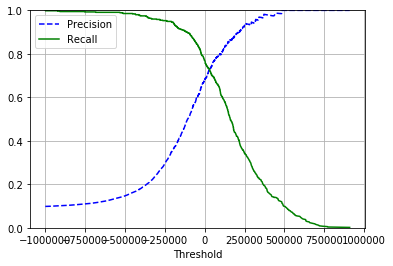

Precision may (or may not) decrease on increasing threshold, Recall will always decrease


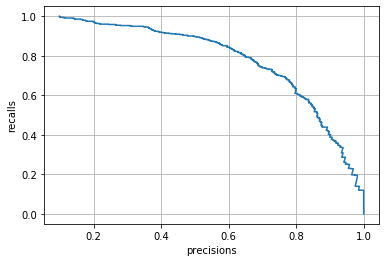

Recall falls of quickly after a certain point, 
 choose precision where recall is also reasonably high for the application


In [18]:
# Now precision and recall can be computed for all possible thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.ylim([0, 1])
  plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
print('Precision may (or may not) decrease on increasing threshold, Recall will always decrease')

plt.plot(precisions, recalls)
plt.xlabel('precisions')
plt.ylabel('recalls')
plt.grid()
plt.show()
print('Recall falls of quickly after a certain point, \n choose precision where recall is also reasonably high for the application')

In [19]:
y_train_pred_90 = y_scores > 200000 
# Let's say we want 90% precision then threshold is correspondingly chosen

print('Precision: ', precision_score(y_train_5, y_train_pred_90))
print('Recall: ', recall_score(y_train_5, y_train_pred_90))

Precision:  0.8923076923076924
Recall:  0.42105263157894735


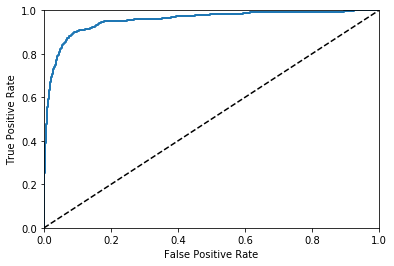

Area under curve (AUC) 0.9549783356575858
Ideal AUC=1, Random classifier AUC = 0.5


In [20]:
# The ROC curve

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

print('Area under curve (AUC)', roc_auc_score(y_train_5, y_scores))
print('Ideal AUC=1, Random classifier AUC = 0.5')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


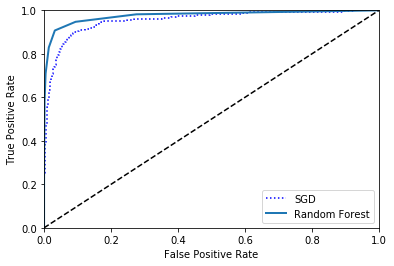

Area under curve (AUC) 0.9759778763582057


In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42) # Does not have a decision_function() rather has predict_proba()

y_probas_forest    = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                              method='predict_proba')

y_scores_forest    = y_probas_forest[:,1] # score = probabilities of positive class

fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)


plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


print('Area under curve (AUC)',roc_auc_score(y_train_5, y_scores_forest))


In [22]:
# Multi Class classification

# Scikit detects when we try to use a binary classification algorithm for a multiclass classification task.
# It automatically runs One vs Rest (except for SVM classifiers where it uses OvO)

sgd_clf.fit(X_train, y_train) # Using all classes in training
sgd_clf.predict([some_digit])


array([5])

In [23]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores, '\n\n maximum score for class:5')

sgd_clf.classes_

[[-624609.2683021   -99343.28090346    9033.79966729 -215313.29647261
    73816.81899469   82793.82578561 -610506.12760767 -940978.80737747
    34588.47044189 -562421.68304932]] 

 maximum score for class:5


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))

len(ovo_clf.estimators_) # 10Choose2 One vs One classifiers for 10 classes = 45

[5]


45

In [25]:
# Random forest classifier has multiclass capability

forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))
      

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[5]
[[0.  0.1 0.2 0.1 0.1 0.5 0.  0.  0.  0. ]]


In [26]:
print('SGDClassifier: ', cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'))

# This is good but can be improved by feature scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

print('SGD with scaled features: ', cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))


SGDClassifier:  [0.85571643 0.862      0.86529795]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SDG with scaled features:  [0.888667   0.889      0.89684527]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [27]:
# Error Analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[[588   0   4   1   3  17   4   0   7   0]
 [  0 621   8   1   0   5   0   2  16   1]
 [  6   4 489  10   8   3  15   8  25   4]
 [  9   6  15 499   1  23   2   6  20   8]
 [  3   2   4   2 518   3   3   2  20  23]
 [ 10   8   8  21   8 451   7   4  28   6]
 [  7   0   6   1  10  15 534   0   7   0]
 [  2   3   6  10   9   2   0 574   4  23]
 [  4   8   5  12   2  21   4   3 517   9]
 [  7   1   5   5  15   2   0  27  12 558]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [37]:
row_sums        = conf_mx.sum(axis=1, keepdims=True) # Normal;ise the conf_mx by number of images in each class
norm_conf_mx    = conf_mx/row_sums

# Fill diagonals with zeros to keep only the errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


# Obeserve that many other digits are predicted as 8 so column (predicted) for 8 is bright
# Also that 5 and 3 are often confused with each other
# Row for 2 is bright so 2 is confused for other digits in prediction


In [0]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

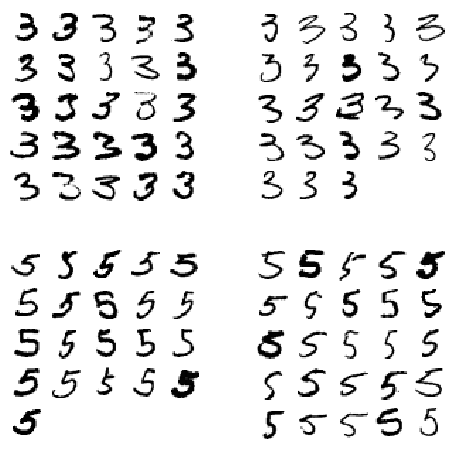

In [45]:
# Let us observe the confusion between 3 and 5

cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


In [49]:
# Multilabel classification

from sklearn.neighbors import KNeighborsClassifier

y_train_large  = y_train >= 7 # Large numbers in y
y_train_odd    = y_train%2 ==1 # Odd digits in y

y_multilabel   = np.c_[y_train_large, y_train_odd]

knn_clf        = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])



array([[False,  True]])